# Basic engine implementation

#### setup

In [11]:
import face_recognition, PIL.Image, PIL.ImageDraw,math
import numpy as np
import logging
import cv2
import platform
from matplotlib import pyplot as plt
from PIL import Image
import scipy.signal as sig

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"

dir = "perry-all-2"
# should be a parameter of the engine
dataset_location = ".." + seperator + "dataset" + seperator + "good_sync" + seperator
specific_dir = dir
video_location = dataset_location + specific_dir + seperator + "test.mp4"


[2021-03-20 01:09:29,046] [INFO] [<module>] [14] : Starting ...


#### Detecting the face landmarks and parsing the ROI

In [12]:
def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.2) # 30 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [13]:
def bad_frame(blue, green, red):
    if red > 95 and green > 40 and blue > 20 and red >green and red > blue:
        return False
    logging.warning("bad frame detected")
    return True

#### Getting RGB values from a frame and adding them to arrays

In [14]:
def parse_RGB(roi, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    try:
        new_red, new_green, new_blue = cv2.split(roi)
    except:
        return False, color_sig
    b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
    if not bad_frame(b_mean,g_mean,r_mean):
        color_channels = roi.reshape(-1, roi.shape[-1])
        avg_color = color_channels.mean(axis=0) 
        color_sig.append(avg_color)
        return True, color_sig
    return False, color_sig

In [15]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [16]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [17]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

In [18]:
def plotSignals(signals, label):
    seconds = np.arange(0, WINDOW_TIME_SEC, 1.0 / FPS)
    colors = ["r", "g", "b"]
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    for i in range(3):
        plt.plot(seconds, signals[:,i], colors[i])
    plt.xlabel('Time (sec)', fontsize=17)
    plt.ylabel(label, fontsize=17)
    plt.tick_params(axis='x', labelsize=17)
    plt.tick_params(axis='y', labelsize=17)
    plt.show()

def plotSpectrum(freqs, powerSpec):
    idx = np.argsort(freqs)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    for i in range(3):
        plt.plot(freqs[idx], powerSpec[idx,i])
    plt.xlabel("Frequency (Hz)", fontsize=17)
    plt.ylabel("Power", fontsize=17)
    plt.tick_params(axis='x', labelsize=17)
    plt.tick_params(axis='y', labelsize=17)
    plt.xlim([0.75, 4])
    plt.show()

In [19]:
from sklearn.decomposition import FastICA
MIN_HR_BPM = 45.0
MAX_HR_BMP = 240.0
SEC_PER_MIN = 60
FPS = 14.99
WINDOW_TIME_SEC = 30
WINDOW_SIZE = int(np.ceil(WINDOW_TIME_SEC * FPS))

def getHeartRate(window):
    # Normalize across the window to have zero-mean and unit variance
    mean = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    normalized = (window - mean) / std

    # Separate into three source signals using ICA
    ica = FastICA()
    srcSig = ica.fit_transform(normalized)

    # Find power spectrum
    powerSpec = np.abs(np.fft.fft(srcSig, axis=0))**2
    freqs = np.fft.fftfreq(WINDOW_SIZE, 1.0 / FPS)

    # Find heart rate
    maxPwrSrc = np.max(powerSpec, axis=1)
    validIdx = np.where((freqs >= MIN_HR_BPM / SEC_PER_MIN) & (freqs <= MAX_HR_BMP / SEC_PER_MIN))
    validPwr = maxPwrSrc[validIdx]
    validFreqs = freqs[validIdx]
    maxPwrIdx = np.argmax(validPwr)
    hr = validFreqs[maxPwrIdx]
    print(hr)

    plotSignals(normalized, "Normalized color intensity")
    plotSignals(srcSig, "Source signal strength")
    plotSpectrum(freqs, powerSpec)

    return hr

#### Main loop - going over all the frames of the video

In [20]:
color_sig = []
heart_rates = []
good_frame_number = 0
total_frame_number = 0

# Parsing video:
logging.info("Working on video " + video_location)
vidcap = cv2.VideoCapture(video_location)
success, image = vidcap.read()
fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
round_fps = np.round(fps)
number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
logging.info("Parsing images ...")
while success:
    logging.info("parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
    rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
    if rois is not None : 
        roi = np.asarray(rois[0])
        is_good_frame,color_sig = parse_RGB(roi, color_sig)
        if is_good_frame:
            good_frame_number += 1
    total_frame_number += 1
    success, image = get_new_frame(vidcap)

[2021-03-20 01:09:29,292] [INFO] [<module>] [7] : Working on video ..\dataset\good_sync\perry-all-2\test.mp4
[2021-03-20 01:09:29,358] [INFO] [<module>] [13] : Parsing images ...
[2021-03-20 01:09:29,359] [INFO] [<module>] [15] : parsing frame 0/810.0
[2021-03-20 01:09:30,489] [INFO] [<module>] [15] : parsing frame 1/810.0
[2021-03-20 01:09:31,467] [INFO] [<module>] [15] : parsing frame 2/810.0
[2021-03-20 01:09:32,424] [INFO] [<module>] [15] : parsing frame 3/810.0
[2021-03-20 01:09:33,390] [INFO] [<module>] [15] : parsing frame 4/810.0
[2021-03-20 01:09:34,372] [INFO] [<module>] [15] : parsing frame 5/810.0
[2021-03-20 01:09:35,350] [INFO] [<module>] [15] : parsing frame 6/810.0
[2021-03-20 01:09:36,335] [INFO] [<module>] [15] : parsing frame 7/810.0
[2021-03-20 01:09:37,309] [INFO] [<module>] [15] : parsing frame 8/810.0
[2021-03-20 01:09:38,285] [INFO] [<module>] [15] : parsing frame 9/810.0
[2021-03-20 01:09:39,251] [INFO] [<module>] [15] : parsing frame 10/810.0
[2021-03-20 01:09

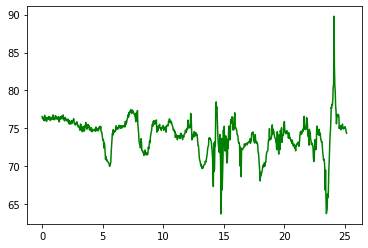

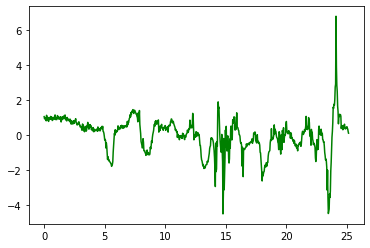

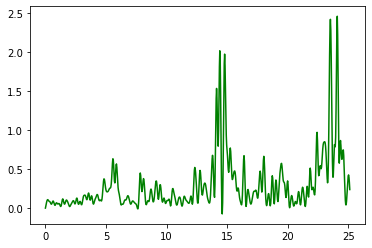

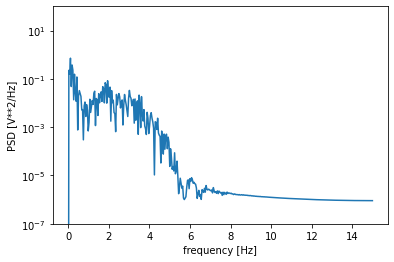

0.11920529801324502


In [24]:
color_sig_array = np.asarray(color_sig)
red = color_sig_array[:,0]
green = color_sig_array[:,1]
blue = color_sig_array[:,2]

green_sig = np.arange(green.size/round_fps,step= (1/30))
plt.plot(green_sig,green,color ='green')
plt.show()


green = green - np.mean(green)
green = green / np.std(green)
plt.plot(green_sig,green,color ='green')
plt.show()

g = filter_channel(green,round_fps)


plt.plot(green_sig,g,color ='green')
plt.show()

f, Pxx_den = sig.periodogram(g, round_fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

max_val = Pxx_den.argmax()
print(f[max_val])


In [ ]:
window_time_sec = 1
window_size = int(np.ceil(window_time_sec * round_fps))

window_start = color_sig.shape[1]
while window_start > window_size :
    window_start -= window_size
    window = color_sig[window_start : window_start + window_size]
    last_hr = heart_rates[-1] if len(heart_rates) > 0 else None
    heart_rates.append(getHeartRate(window))

In [ ]:
if frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'

In [ ]:
window_time_sec = 1
window_size = int(np.ceil(window_time_sec * round_fps))

window_start = color_sig.shape[1]
while window_start > window_size :
    window_start -= window_size
    window = color_sig[window_start : window_start + window_size]
    last_hr = heart_rates[-1] if len(heart_rates) > 0 else None
    heart_rates.append(getHeartRate(window))

In [ ]:
getHeartRate(color_sig)

In [ ]:
if frame_number != greens.size: # TO BE REVIEW BY EYAL, POSSIBLE BUG FIX HERE!
    frame_number = greens.size
axis = np.arange((frame_number / round_fps), step=(1 / 30)) # axis is Time
plot_result(greens, reds, blues, axis, "All 3 channels") # original signals
# apply filtering on all the channels:
green_buttered = filter_channel(greens,round_fps)
red_buttered = filter_channel(reds,round_fps)
blue_buttered = filter_channel(blues,round_fps)
# plotting the channels after apllying the filter
plot_result(green_buttered, red_buttered, blue_buttered, axis, "After Filter") # after filtering

### PSD estimation using 'Welch' or 'Periodogram'



In [ ]:
f, Pxx_den = sig.welch(green_buttered, round_fps,'flattop', 1024, scaling='spectrum')

### Plot final results

In [ ]:
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
# periodogram method:
f, Pxx_den = sig.periodogram(green_buttered, round_fps)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()